In [ ]:
from pathlib import Path
from src.hrv_epatch.study5_pipeline import Study5Paths, Study5Cfg, run_study5, load_window_quality, load_df_seiz

# SeizureTimeAxis = Literal["clinical", "video", "default"]
DATASTRUCT_ROOT = Path(r"E:\Speciale - Results\Datastruct")
MAIN_DATA_ROOT  = Path(r"E:\Speciale - Results")
STUDY2_ROOT     = Path(MAIN_DATA_ROOT / "study2")
STUDY3_ROOT     = Path(MAIN_DATA_ROOT / "study3")
STUDY4_ROOT     = Path(MAIN_DATA_ROOT / "study4")

PATH_REC = DATASTRUCT_ROOT / "recordings_index.csv"
PATH_SEIZURE = DATASTRUCT_ROOT / "seizure_events.csv"
PATH_WINDOW_QUALITY = STUDY2_ROOT / "window_quality_baseline_vs_seizure.csv"

# hvor du evt. vil gemme mellem- og slutresultater til Study4
STUDY4_OUT = Path(MAIN_DATA_ROOT  / "study4")
STUDY4_OUT.mkdir(parents=True, exist_ok=True)

STUDY5_OUT = Path(MAIN_DATA_ROOT  / "study5")
STUDY5_OUT.mkdir(parents=True, exist_ok=True)

# %%
paths = Study5Paths(
        rr_dir=Path(MAIN_DATA_ROOT / "Final_RR_alignment" / "Test_aligned_rr_Trim"),
        recordings_index_csv=Path(DATASTRUCT_ROOT / "recordings_index.csv"),
        seizure_events_csv=Path(DATASTRUCT_ROOT / "seizure_events.csv"),
        window_quality_csv=Path(STUDY2_ROOT / "window_quality_baseline_vs_seizure.csv"),
        threshold_xlsx=Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values.xlsx"),
    )

# df_winq = pd.read_csv(paths.window_quality_csv)
# print(df_winq.columns.tolist())

# Optional filters
algo_keep = {"hamilton2002", "neurokit", "pantompkins1985", "emrich2023"}
recording_uid_keep = {6,11}  # e.g. {4,5,9,11} for pilot

responders = [3, 5, 6, 8, 14, 15, 16, 21, 23, 27, 28, 29, 31, 34, 37, 39, 40, 41, 42]

cfg = Study5Cfg(
    win_rr=100,
    value_mode="modcsi",          # eller "csi"
    algo_keep={"neurokit"},       # optional
    use_excel_thresholds=False,   # True hvis du VIL tvinge Excel
    responders=None,              # eller [..]
)

In [ ]:
out = run_study5(paths, cfg)

df_feat5 = out.df_feat5
df_main  = out.df_main
df_split = out.df_split
thr_meta_modcsi = out.thr_meta_modcsi

In [ ]:
df_evt = load_df_seiz(paths.seizure_events_csv)

In [2]:
pid = 40

# 1) Hvad endte thresholds med at være i df_feat5 (det er dem scoringen bruger)?
cols = [c for c in ["patient_id","rr_source","algo_id","thr_modcsi","thr_csi"] if c in df_feat5.columns]
display(
    df_feat5.loc[df_feat5["patient_id"] == pid, cols]
      .drop_duplicates()
      .sort_values([c for c in ["rr_source","algo_id"] if c in cols])
      .head(50)
)

# 2) Auto-threshold metadata (hvis du brugte auto)
if out.thr_meta_modcsi is not None and len(out.thr_meta_modcsi) > 0:
    display(out.thr_meta_modcsi[out.thr_meta_modcsi["patient_id"] == pid])

if hasattr(out, "thr_meta_csi") and out.thr_meta_csi is not None and len(out.thr_meta_csi) > 0:
    display(out.thr_meta_csi[out.thr_meta_csi["patient_id"] == pid])

# 3) Excel thresholds (hvis loadet)
if hasattr(out, "thr_excel_modcsi") and out.thr_excel_modcsi:
    print("Excel thr_modcsi:", out.thr_excel_modcsi.get(pid))

if hasattr(out, "thr_excel_csi") and out.thr_excel_csi:
    print("Excel thr_csi:", out.thr_excel_csi.get(pid))


,patient_id,rr_source,algo_id,thr_modcsi,thr_csi
25735812,40,labview,LabVIEW,31203.069984,25.062864
25908974,40,python,neurokit,31203.069984,25.062864


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
39,40,first_24h,67,0.0,86400.0,29717.209508,1.05,31203.069984,False


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
39,40,first_24h,67,0.0,86400.0,23.869395,1.05,25.062864,False


In [3]:
# hvor mange events i alt pr algo/rr_source?
display(
    df_feat5.groupby(["rr_source","algo_id"], dropna=False)["t_s"]
      .count()
      .rename("n_points")
      .reset_index()
      .sort_values(["rr_source","algo_id"])
)

# hvis df_events findes i din pipeline-output (nogle versioner gemmer det)
if hasattr(out, "df_events") and out.df_events is not None:
    display(
        out.df_events.groupby(["rr_source","algo_id"])["recording_uid"]
          .count()
          .rename("n_events")
          .reset_index()
          .sort_values(["rr_source","algo_id"])
    )


,rr_source,algo_id,n_points
0,labview,LabVIEW,14034938
1,python,neurokit,14034938


In [14]:
# find hvilke df'er du har i scope
[x for x in ["df_evt","df_seiz","df_seiz_trim","df_events","out"] if x in globals()]

['out']

In [15]:
type(out)
list(vars(out).keys())


['df_feat5',
 'df_main',
 'df_split',
 'thr_meta_modcsi',
 'thr_meta_csi',
 'thr_map_modcsi',
 'thr_map_csi']

In [23]:
pid = 40

# hvilke recordings har patienten anfald i?
print(df_evt.loc[df_evt["patient_id"] == pid, ["recording_uid","seizure_id","t0_trim","t1_trim"]].head(20))

# vælg en recording_uid (fx den første)
rid = int(df_evt.loc[df_evt["patient_id"] == pid, "recording_uid"].iloc[0])

# se hvilke rr_source/algo_id der findes i df_feat5 for netop den recording
avail = (
    df_feat5.loc[(df_feat5["patient_id"] == pid) & (df_feat5["recording_uid"] == rid),
                 ["rr_source","algo_id"]]
    .drop_duplicates()
    .sort_values(["rr_source","algo_id"])
)
print("Available (rr_source, algo_id) combos:")
print(avail.to_string(index=False))


     recording_uid  seizure_id   t0_trim   t1_trim
141             67           1  157070.0  157132.0
142             68           2   54173.0   54213.0
143             68           3   71107.0   71136.0
Available (rr_source, algo_id) combos:
rr_source  algo_id
  labview  LabVIEW
   python neurokit


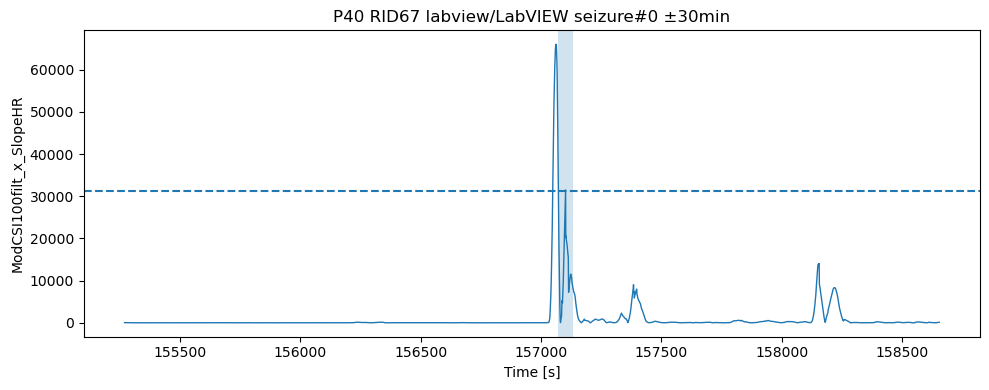

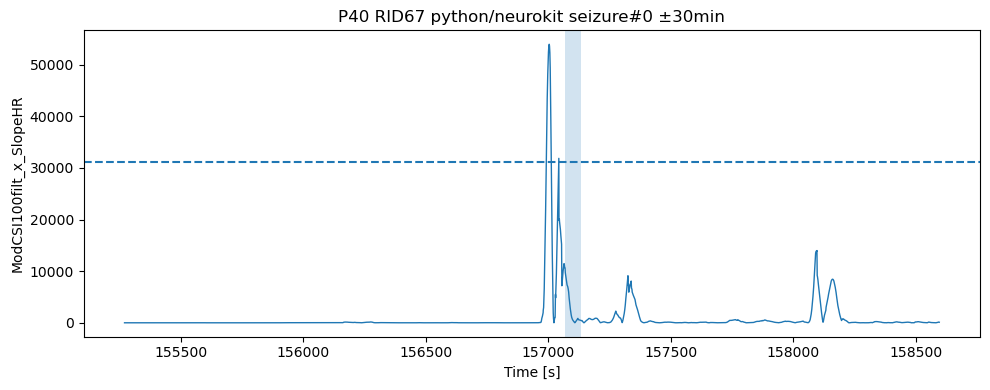

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_around_seizure(
    df_feat5, df_evt, *,
    patient_id: int,
    rr_source="labview",
    algo_id="neurokit",
    value_col="ModCSI100filt_x_SlopeHR",
    t0_col="t0_trim",
    t1_col="t1_trim",
    seizure_idx=0,
    pad_s=1800,
):
    # seizure rows for patient
    seiz_p = df_evt[df_evt["patient_id"] == patient_id].copy()
    seiz_p = seiz_p.dropna(subset=[t0_col, t1_col])
    if seiz_p.empty:
        raise ValueError(f"No seizures with usable {t0_col}/{t1_col} for patient {patient_id}.")

    # choose which seizure to plot
    seiz_p = seiz_p.sort_values(["recording_uid", t0_col]).reset_index(drop=True)
    if seizure_idx >= len(seiz_p):
        raise ValueError(f"seizure_idx={seizure_idx} out of range (n={len(seiz_p)}).")

    srow = seiz_p.iloc[seizure_idx]
    rid = int(srow["recording_uid"])
    t0 = float(srow[t0_col]); t1 = float(srow[t1_col])

    # feature rows for same patient/recording/source/algo
    f = df_feat5[
        (df_feat5["patient_id"] == patient_id) &
        (df_feat5["recording_uid"] == rid) &
        (df_feat5["rr_source"].astype(str).str.lower() == str(rr_source).lower()) &
        (df_feat5["algo_id"].astype(str).str.lower() == str(algo_id).lower())
    ].copy()

    if f.empty:
        raise ValueError("No feature rows match selection (patient/recording/rr_source/algo_id).")

    # threshold column choice
    thr_col = "thr_modcsi" if "modcsi" in value_col.lower() else "thr_csi"
    thr = np.nan
    if thr_col in f.columns and f[thr_col].notna().any():
        thr = float(f[thr_col].dropna().iloc[0])

    # window around seizure
    a = max(0.0, t0 - pad_s)
    b = t1 + pad_s
    f = f[(f["t_s"] >= a) & (f["t_s"] <= b)].sort_values("t_s")

    fig = plt.figure(figsize=(10, 4))
    plt.plot(f["t_s"], f[value_col], linewidth=1)

    if np.isfinite(thr):
        plt.axhline(thr, linestyle="--")

    plt.axvspan(t0, t1, alpha=0.2)
    plt.xlabel("Time [s]")
    plt.ylabel(value_col)
    plt.title(f"P{patient_id} RID{rid} {rr_source}/{algo_id} seizure#{seizure_idx} ±{pad_s/60:.0f}min")
    plt.tight_layout()
    return fig

rr_source = "labview"
algo_id   = avail.loc[avail["rr_source"].str.lower().eq("labview"), "algo_id"].iloc[0]

fig = plot_feature_around_seizure(
    df_feat5, df_evt,
    patient_id=pid,
    rr_source=rr_source,
    algo_id=algo_id,
    value_col="ModCSI100filt_x_SlopeHR",
    pad_s=1800,
    seizure_idx=0,
)
plt.show()

rr_source = "python"
algo_id   = "neurokit"  # kun hvis den findes i avail!

fig = plot_feature_around_seizure(
    df_feat5, df_evt,
    patient_id=pid,
    rr_source=rr_source,
    algo_id=algo_id,
    value_col="ModCSI100filt_x_SlopeHR",
    pad_s=1800,
    seizure_idx=0,
)
plt.show()


In [25]:
pid = 40
print("thr_modcsi:", out.thr_map_modcsi.get(pid))
print("thr_csi:", out.thr_map_csi.get(pid))

display(out.thr_meta_modcsi[out.thr_meta_modcsi.get("patient_id").eq(pid)] if "patient_id" in out.thr_meta_modcsi.columns else out.thr_meta_modcsi)
display(out.df_main)
display(out.df_split)


thr_modcsi: 31203.069983581216
thr_csi: 25.062864273467525


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
39,40,first_24h,67,0.0,86400.0,29717.209508,1.05,31203.069984,False


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used
0,LabVIEW,—,off,149,149,36,0.241611,0.241611,103,0.032463,3172.855556,141,72
1,LabVIEW,—,on,149,149,36,0.241611,0.241611,102,0.032421,3146.155556,140,72
2,Python,neurokit,off,149,149,39,0.261745,0.261745,104,0.032778,3172.855556,143,72
3,Python,neurokit,on,149,149,39,0.261745,0.261745,105,0.033374,3146.155556,144,72


""


In [ ]:
sample_pids = (df_feat5["patient_id"].dropna().astype(int).drop_duplicates().sample(5, random_state=7).tolist())

df_thr_examples = (df_feat5.loc[df_feat5["patient_id"].isin(sample_pids),
                                ["patient_id","rr_source","algo_id","thr_modcsi","thr_csi"]]
                   .drop_duplicates(subset=["patient_id","rr_source","algo_id"])
                   .sort_values(["patient_id","rr_source","algo_id"])
                  )

display(df_thr_examples)
df_thr_examples.to_csv(out_dir / "study5_threshold_examples_5patients.csv", index=False)


In [26]:
fL = df_feat5[(df_feat5.patient_id==40)&(df_feat5.recording_uid==67)&(df_feat5.rr_source=="labview")]
fP = df_feat5[(df_feat5.patient_id==40)&(df_feat5.recording_uid==67)&(df_feat5.rr_source=="python")]

print("t_end LabVIEW:", fL["t_s"].iloc[-1])
print("t_end Python :", fP["t_s"].iloc[-1])
print("delta end (P-L):", fP["t_s"].iloc[-1] - fL["t_s"].iloc[-1])


t_end LabVIEW: 158654.3919696808
t_end Python : 158594.708984375
delta end (P-L): -59.68298530578613


In [27]:
df_report = out.df_main.copy()
df_report.to_csv(STUDY5_OUT/"study5_main_overview.csv", index=False)
display(df_report)


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used
0,LabVIEW,—,off,149,149,36,0.241611,0.241611,103,0.032463,3172.855556,141,72
1,LabVIEW,—,on,149,149,36,0.241611,0.241611,102,0.032421,3146.155556,140,72
2,Python,neurokit,off,149,149,39,0.261745,0.261745,104,0.032778,3172.855556,143,72
3,Python,neurokit,on,149,149,39,0.261745,0.261745,105,0.033374,3146.155556,144,72


In [28]:
out.df_split.to_csv(STUDY5_OUT/"study5_split_overview.csv", index=False)
display(out.df_split.head(20))


""


In [29]:
thr = out.thr_meta_modcsi.copy()
thr.to_csv(STUDY5_OUT/"study5_threshold_meta_modcsi.csv", index=False)

# kort “rapport-view”
display(
    thr.groupby(["mode_used"])["threshold"]
       .describe(percentiles=[0.1,0.5,0.9])[["10%","50%","90%"]]
)


,10%,50%,90%
mode_used,,,
first_12h,6391.042583,10006.118157,14589.831176
first_24h,4472.393822,16047.418285,31000.377100
global_max,11341.065292,21731.335270,60023.199825


In [30]:
thr24 = thr[thr["mode_used"]=="first_24h"].sort_values("patient_id")
display(thr24[["patient_id","recording_uid_used","max_value_in_segment","threshold","fallback_used"]].head(15))


,patient_id,recording_uid_used,max_value_in_segment,threshold,fallback_used
0,1,0,16025.625608,16826.906889,False
5,6,7,14606.724987,15337.061237,False
7,8,11,12771.771725,13410.360312,False
9,10,16,24125.136076,25331.392880,False
10,11,17,14278.553764,14992.481452,False
11,12,19,17458.473207,18331.396867,False
13,14,23,27786.801088,29176.141143,False
14,15,25,4104.753385,4309.991054,False
15,16,27,39767.524575,41755.900804,False
17,18,29,67561.479730,70939.553717,False


In [34]:
import numpy as np
import pandas as pd
from pathlib import Path

def make_sqi_variants(w: pd.DataFrame) -> dict[str, pd.Series]:
    w = w.copy()

    # Baseline threshold-niveauer fra dine data (globale percentiler)
    std_p95  = float(np.nanpercentile(w["std"], 95))
    std_p97  = float(np.nanpercentile(w["std"], 97))
    diff_p95 = float(np.nanpercentile(w["diff_abs_med"], 95))

    v = {}

    # V0: brug eksisterende
    v["V0_existing"] = w["is_acceptable"].astype(bool)

    # V1: accept hvis ingen flags (klassisk og let at forklare)
    v["V1_flags_only"] = ~(w["is_flatline"] | w["is_noiseburst"] | w["is_clipping"])

    # V2: strengere: ingen flags + std under p95 (fjerner de “mest støjende” vinduer)
    v["V2_flags_std_p95"] = v["V1_flags_only"] & (w["std"] <= std_p95)

    # V3: endnu strengere: + diff_abs_med under p95 (mere følsom overfor “hak/støj”)
    v["V3_flags_std_p97_diff_p95"] = v["V1_flags_only"] & (w["std"] <= std_p97) & (w["diff_abs_med"] <= diff_p95)

    return v

def run_sqi_sweep(paths, cfg, out_base: Path):
    out_base.mkdir(parents=True, exist_ok=True)

    w = load_window_quality(paths.window_quality_csv)
    variants = make_sqi_variants(w)

    rows = []
    outs = {}

    for name, mask in variants.items():
        w2 = w.copy()
        w2["is_acceptable"] = mask.astype(bool)

        tmp_csv = out_base / f"window_quality_{name}.csv"
        w2.to_csv(tmp_csv, index=False)

        # lav en ny paths med den nye window quality
        paths2 = Study5Paths(**{**paths.__dict__, "window_quality_csv": str(tmp_csv)})

        out = run_study5(paths2, cfg)
        outs[name] = out

        # tag kun det vigtigste til en sweep-tabel
        dfm = out.df_main.copy()
        dfm["sqi_variant"] = name
        rows.append(dfm)

    df_sweep = pd.concat(rows, ignore_index=True)
    df_sweep.to_csv(out_base / "study5_sqi_sweep_summary.csv", index=False)

    return df_sweep, outs


In [35]:
df_sweep, outs = run_sqi_sweep(paths, cfg, out_base=Path(STUDY5_OUT / "sqi_sweep"))
display(df_sweep)


,RR_source,Algorithm,SQI,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used,sqi_variant
0,LabVIEW,—,off,149,149,36,0.241611,0.241611,103,0.032463,3172.855556,141,72,V0_existing
1,LabVIEW,—,on,149,149,36,0.241611,0.241611,102,0.032421,3146.155556,140,72,V0_existing
2,Python,neurokit,off,149,144,39,0.261745,0.270833,99,0.031202,3172.855556,138,70,V0_existing
3,Python,neurokit,on,149,144,39,0.261745,0.270833,100,0.031785,3146.155556,139,70,V0_existing
4,LabVIEW,—,off,149,149,36,0.241611,0.241611,103,0.032463,3172.855556,141,72,V1_flags_only
5,LabVIEW,—,on,149,149,36,0.241611,0.241611,102,0.032421,3146.155556,140,72,V1_flags_only
6,Python,neurokit,off,149,149,39,0.261745,0.261745,104,0.032778,3172.855556,143,72,V1_flags_only
7,Python,neurokit,on,149,149,39,0.261745,0.261745,105,0.033374,3146.155556,144,72,V1_flags_only
8,LabVIEW,—,off,149,149,38,0.255034,0.255034,154,0.048537,3172.855556,194,72,V2_flags_std_p95
9,LabVIEW,—,on,149,149,32,0.214765,0.214765,118,0.039226,3008.197222,152,72,V2_flags_std_p95


In [36]:
cols = ["sqi_variant","RR_source","Algorithm","SQI","n_seiz_total_used","n_seiz_detected","recall_used","FP_events","FAR_per_h","total_h"]
display(df_sweep[cols].sort_values(["sqi_variant","RR_source","Algorithm","SQI"]))


,sqi_variant,RR_source,Algorithm,SQI,n_seiz_total_used,n_seiz_detected,recall_used,FP_events,FAR_per_h,total_h
0,V0_existing,LabVIEW,—,off,149,36,0.241611,103,0.032463,3172.855556
1,V0_existing,LabVIEW,—,on,149,36,0.241611,102,0.032421,3146.155556
2,V0_existing,Python,neurokit,off,144,39,0.270833,99,0.031202,3172.855556
3,V0_existing,Python,neurokit,on,144,39,0.270833,100,0.031785,3146.155556
4,V1_flags_only,LabVIEW,—,off,149,36,0.241611,103,0.032463,3172.855556
5,V1_flags_only,LabVIEW,—,on,149,36,0.241611,102,0.032421,3146.155556
6,V1_flags_only,Python,neurokit,off,149,39,0.261745,104,0.032778,3172.855556
7,V1_flags_only,Python,neurokit,on,149,39,0.261745,105,0.033374,3146.155556
8,V2_flags_std_p95,LabVIEW,—,off,149,38,0.255034,154,0.048537,3172.855556
9,V2_flags_std_p95,LabVIEW,—,on,149,32,0.214765,118,0.039226,3008.197222


In [37]:
base = df_sweep[df_sweep["sqi_variant"]=="V0_existing"].set_index(["RR_source","Algorithm","SQI"])
cur  = df_sweep[df_sweep["sqi_variant"]=="V3_flags_std_p97_diff_p95"].set_index(["RR_source","Algorithm","SQI"])
delta = (cur[["recall_used","FAR_per_h"]] - base[["recall_used","FAR_per_h"]]).reset_index()
display(delta)


,RR_source,Algorithm,SQI,recall_used,FAR_per_h
0,LabVIEW,—,off,0.013423,0.009770
1,LabVIEW,—,on,-0.053691,0.003782
2,Python,neurokit,off,0.006194,0.011977
3,Python,neurokit,on,-0.047860,0.005771


In [38]:
def summarize_mask_rate(w: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "n_windows": [len(w)],
        "frac_acceptable": [float(w["is_acceptable"].mean())],
        "frac_masked": [float((~w["is_acceptable"]).mean())],
        "frac_noiseburst": [float(w["is_noiseburst"].mean())],
        "frac_flatline": [float(w["is_flatline"].mean())],
        "frac_clipping": [float(w["is_clipping"].mean())],
    })

w = load_window_quality(paths.window_quality_csv)
for name, mask in make_sqi_variants(w).items():
    w2 = w.copy()
    w2["is_acceptable"] = mask
    print(name)
    display(summarize_mask_rate(w2))


V0_existing


,n_windows,frac_acceptable,frac_masked,frac_noiseburst,frac_flatline,frac_clipping
0,1142228,0.991585,0.008415,0.008412,0.0,0.000037


V1_flags_only


,n_windows,frac_acceptable,frac_masked,frac_noiseburst,frac_flatline,frac_clipping
0,1142228,0.991585,0.008415,0.008412,0.0,0.000037


V2_flags_std_p95


,n_windows,frac_acceptable,frac_masked,frac_noiseburst,frac_flatline,frac_clipping
0,1142228,0.948104,0.051896,0.008412,0.0,0.000037


V3_flags_std_p97_diff_p95


,n_windows,frac_acceptable,frac_masked,frac_noiseburst,frac_flatline,frac_clipping
0,1142228,0.931534,0.068466,0.008412,0.0,0.000037
